<a href="https://colab.research.google.com/github/chettkulkarni/advanced_deep_learning/blob/master/Assignment_1/Assignment_1_Part_2/Assignment_1_Part_2_SemiSupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SemiSupervised Learning

As the name suggest when we do machne learning with some supersion, but there is some data that is missing, and machine needs to learn the missing part on its own.
That is part Supervised and Part Unsupervised

## Why SemiSupervised Learning?
In real life examples we might not have concrete information about everything , hence having a mechanism which leverages known information and uses that information to build on that is very crucial

Problem: Find out if the Loan can be given to the user or not

Data Source:- UCI Machine Learning Repo

More Information about Data Source

Source Credits:

Professor Dr. Hans Hofmann

Institut f"ur Statistik und "Okonometrie

Universit"at Hamburg

FB Wirtschaftswissenschaften

Von-Melle-Park 5 2000 Hamburg 13


About Data: The Data has 1000 rows and 25 columns, about credit approval process

## Importing Libraries

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading The Data

German Data has 30 Columns and each column.
We need to perform binary classification using SemiSupervised Learning


In [2]:
# Load the data

data=pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric',delim_whitespace=True,header=None)
columns = [
'checking_account',
'duration',
'credit_history',
'credit_amount',
'saving_account',
'present_emp_since',
'personal_status',
'residence_since',
'property',
'age',
'inst_plans',
'num_credits',
'dependents',
'telephone',
'foreign_worker',
'new_car',
'used_car',
'Debtors_None',
'Debtors_CoApplicant',
'Rent_hose',
'Own_Hose',
'Unemployed_And_Unskilled_Non_res',
'Unskilled_resident',
'skilled_official',
'status'
]
data.columns=columns

def changeCol(x):
  if x==1:
    return 1
  return 0

dataX = data.copy().drop(['status'],axis=1)
dataY = data['status'].apply(lambda x: changeCol(x))

# Scale data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

# Split into train and test
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY) 

## Dropping sme labels to make Data suitable for SemiSupervised learning

In [3]:
# Drop 95% of the labels from the training set
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
y_train

571    1
496    0
578    0
29     0
521    0
      ..
958    0
648    0
435    0
598    0
265    0
Name: status, Length: 248, dtype: int64

## Helper Functions

Anomaly Scores and precision scores are two techniques with which we can test the performance of model. 
Hence we are creating 2 functions which can give us precision scores and Anomaly Scores


In [5]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [ ]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

### plot Results will use the anamoly scores and Label vs prediction to produce a visual plots, which can help us compare performance of models

In [6]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

### Testing Paradigm

We are using Kfold testing technique, to test the performacne of the model

In [12]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True)

## Supervised Learning using Light Gb

here we will try to learn labelled datset using LightSB model

Run thr training loop and observe the results

In [13]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [14]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.499781
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.498641
[3]	valid_0's binary_logloss: 0.497538
[4]	valid_0's binary_logloss: 0.496471
[5]	valid_0's binary_logloss: 0.495439
[6]	valid_0's binary_logloss: 0.494441
[7]	valid_0's binary_logloss: 0.493173
[8]	valid_0's binary_logloss: 0.491676
[9]	valid_0's binary_logloss: 0.490218
[10]	valid_0's binary_logloss: 0.488798
[11]	valid_0's binary_logloss: 0.487414
[12]	valid_0's binary_logloss: 0.486584
[13]	valid_0's binary_logloss: 0.485259
[14]	valid_0's binary_logloss: 0.484139
[15]	valid_0's binary_logloss: 0.48288
[16]	valid_0's binary_logloss: 0.482149
[17]	valid_0's binary_logloss: 0.480941
[18]	valid_0's binary_logloss: 0.47994
[19]	valid_0's binary_logloss: 0.478791
[20]	valid_0's binary_logloss: 0.478149
[21]	valid_0's binary_logloss: 0.477047
[22]	valid_0's binary_logloss: 0.476463
[23]	valid_0's binary_logloss: 0.475634
[24]	valid_0's binary_loglos

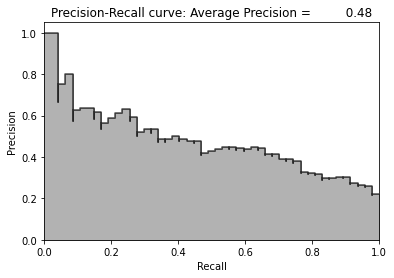

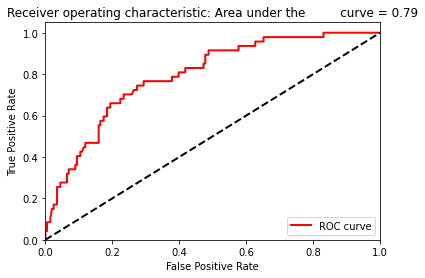

In [15]:
preds, average_precision = plotResults(y_train, predictionsBasedOnKFolds.loc[:,'prediction'], True)

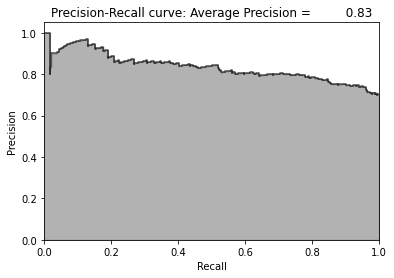

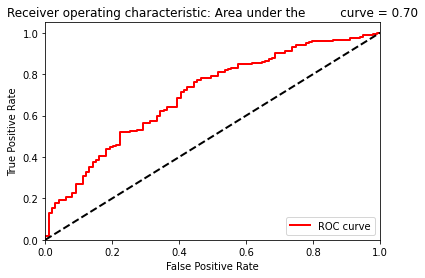

In [16]:
predictions = pd.Series(data=gbm.predict(X_test,num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [17]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.7990867579908676


## Unsupervised learning
here we will create a neural network to learn the data using unsupervsed learning.

The model will have a hidden layer, and optimser is adam optimiser and loss function is mean squared_error.

In [18]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [23]:
model = Sequential()
model.add(Dense(units=40, activation='linear', \
                activity_regularizer=regularizers.l1(10e-5), \
                input_dim=24,name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=24, activation='linear'))

In [24]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [26]:
num_epochs = 20
batch_size = 32

history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Epoch 1/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0296 - accuracy: 0.9192 - val_loss: 0.0069 - val_accuracy: 0.9788
Epoch 2/20
124/124 [==============================] - 0s 2ms/step - loss: 0.0263 - accuracy: 0.9378 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 3/20
124/124 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9464 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 4/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9426 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 5/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0201 - accuracy: 0.9512 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/20
124/124 [==============================] - 0s 2ms/step - loss: 0.0186 - accuracy: 0.9538 - val_loss: 0.0030 - val_accuracy: 0.9788
Epoch 7/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0180 - accuracy: 0.9424 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 

8/8 [==============================] - 0s 1ms/step


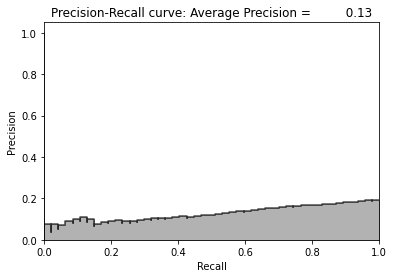

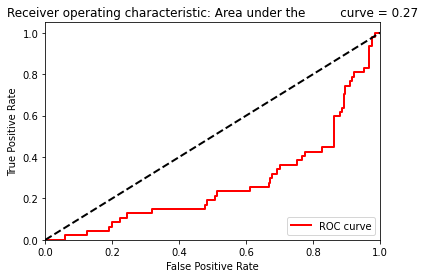

In [27]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, \
                                      anomalyScoresAETrain, True)

11/11 [==============================] - 0s 986us/step


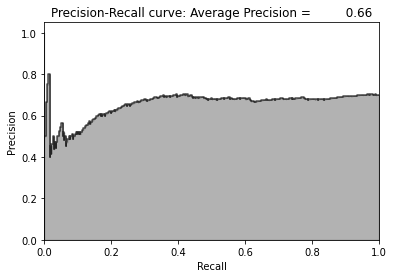

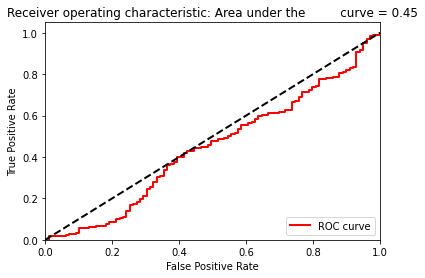

In [28]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [29]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.68359375


## Semi Supervised Learning

In this we will leavaerage both the supervised and unspervised learning technique.

In [30]:
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs=model.input, \
                                 outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test = intermediate_layer_model.predict(X_test_original)

In [31]:
intermediate_output_trainDF = \
    pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)
intermediate_output_testDF = \
    pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)

In [32]:
X_train = X_train_original.merge(intermediate_output_trainDF, \
                                 left_index=True,right_index=True)
X_test = X_test_original.merge(intermediate_output_testDF, \
                               left_index=True,right_index=True)
y_train = y_train_original.copy()

In [33]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, 
                                gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
            predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
                        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.499263
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.497557
[3]	valid_0's binary_logloss: 0.495986
[4]	valid_0's binary_logloss: 0.494542
[5]	valid_0's binary_logloss: 0.493065
[6]	valid_0's binary_logloss: 0.491694
[7]	valid_0's binary_logloss: 0.490305
[8]	valid_0's binary_logloss: 0.488894
[9]	valid_0's binary_logloss: 0.487343
[10]	valid_0's binary_logloss: 0.486085
[11]	valid_0's binary_logloss: 0.48603
[12]	valid_0's binary_logloss: 0.485076
[13]	valid_0's binary_logloss: 0.483788
[14]	valid_0's binary_logloss: 0.483775
[15]	valid_0's binary_logloss: 0.482612
[16]	valid_0's binary_logloss: 0.482634
[17]	valid_0's binary_logloss: 0.481764
[18]	valid_0's binary_logloss: 0.480576
[19]	valid_0's binary_logloss: 0.480635
[20]	valid_0's binary_logloss: 0.479526
[21]	valid_0's binary_logloss: 0.478395
[22]	valid_0's binary_logloss: 0.478488
[23]	valid_0's binary_logloss: 0.477438
[24]	valid_0's binary_loglo

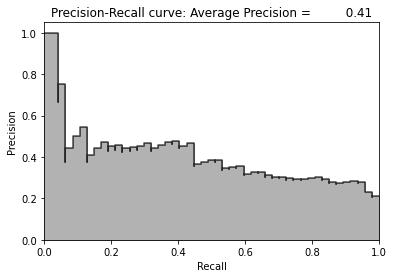

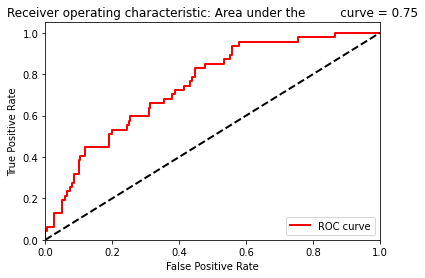

In [34]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

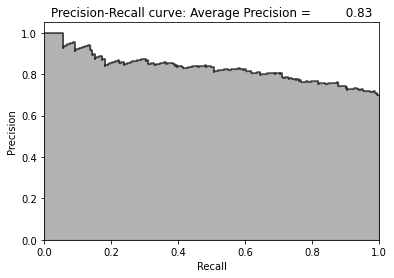

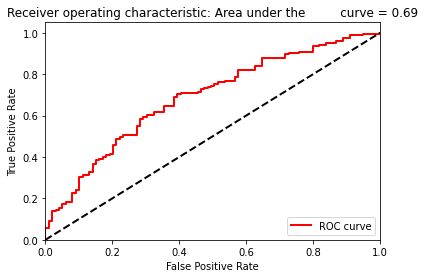

In [35]:
predictions = pd.Series(data=gbm.predict(X_test, \
                    num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [36]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

0.7743362831858407


In [37]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), \
                        index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', \
                               ascending=False,inplace=True)
featuresImportance

,featImportance
11,0.140257
12,0.120985
17,0.067452
1,0.054604
3,0.049251
...,...
used_car,0.000000
Own_Hose,0.000000
24,0.000000
Debtors_None,0.000000


In the above example , the learning happened using 3 techniques


1.   Using Supervised Learning, we were able to reach 79% accuracy
2.   Using Unsupervised learning, we were able to reach 68% accuracy
3.   With Semi Supervised learning, we reached 78%. but in this case, we have leveraged all the data available making it more useful approach

In real life situations, we will have semi labelled dataset , and this technique will be very useful during those times.

